In [338]:
#titanic
# TODO: create family size variable, use cabin to get floor
# TODO: feature scaling or mean normalization?
# TODO You can standardize the digits data by, for example, making use of the scale() method:

import pandas as pd
import numpy as np
#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
#import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [10]:
a = ['a', 'b']
for x in a:
    print(x)
    if x not in a:
        print 'fgg''
    

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-10-6ebb07a821c9>, line 5)

data dictionary

#Variable	Definition	Key
#survival	Survival	0 = No, 1 = Yes
#pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
#sex	Sex	
#Age	Age in years	
#sibsp	# of siblings / spouses aboard the Titanic	
#parch	# of parents / children aboard the Titanic	
#ticket	Ticket number	
#fare	Passenger fare	
#cabin	Cabin number	
#embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Start by loading training and test sets and looking at their key features

In [339]:
titanic_df = pd.read_csv('C:/Users/blahjays/Documents/MachineLearning/Kaggle/train.csv')
titanic_test= pd.read_csv('C:/Users/blahjays/Documents/MachineLearning/Kaggle/test.csv')

titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [340]:
# shape is 891,12
#print(titanic_df.shape)
# take a look at the first few rows
print(titanic_df.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


#Reusable Functions section
define functions that can call for both test and training sets

In [341]:
# predefine mappings
embark_mapping = {"S": 0, "C": 1, "Q": 2}
sex_mapping = {"male": 0, "female": 1}
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5}

In [342]:
# this function converts Embarked feature to numeric value
def encodeEmbark(my_df):

    # in training set, there are 2 NA values and vast majority of users embarked at S, so just default those two users to S
    my_df['Embarked'] = my_df['Embarked'].fillna("S")
    my_df['Embarked'] = my_df['Embarked'].map(embark_mapping).astype(int)
    return my_df


In [343]:
def createFamilySize(my_df):
    my_df['FamilySize'] = my_df['SibSp'] + my_df['Parch']
    return my_df


In [344]:
def cleanupTitles(my_df):
    # first fill out titles
    # add a computed title column
    my_df['Title'] = my_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(my_df['Title'], my_df['Sex'])

    # replace rare titles
    my_df['Title'] = my_df['Title'].replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs').replace('Countess', 'Mrs').replace('Lady', 'Mrs')
    my_df['Title'] = my_df['Title'].replace('Jonkheer', 'Mr').replace('Don', 'Mr').replace('Capt', 'Mr').replace('Col', 'Mr')
    my_df['Title'] = my_df['Title'].replace('Major', 'Mr').replace('Sir', 'Mr').replace('Rev', 'Mr')
    
    #finally map title to numeric index
    my_df['Title'] = my_df['Title'].map(title_mapping)
    # replace any missing titles with 0
    my_df['Title'] = my_df['Title'].fillna(0)
    return my_df


In [345]:
# convert title values to number
#now get average age for each title
def fillMissingAges(my_df):
    #first get average age for each title as a dictionary
    title_avg_age_df = my_df[['Age' , 'Title']].groupby(['Title']).mean()
    age_mapping = title_avg_age_df.to_dict()
    # fill NA age values with average age for that title
    #map the average age based on title to the missing age values (nan)
    my_df['Age'] = my_df['Age'].fillna(my_df['Title'].map((age_mapping['Age'])))
    return my_df


Feature exploration section
take a closer look at some of the key features

In [346]:
# Distribution of PClass Feature
# most are in 3rd class as would expect
# seems a little odd that are more in first class than second class though
print(titanic_df.groupby('Pclass').size())

Pclass
1    216
2    184
3    491
dtype: int64


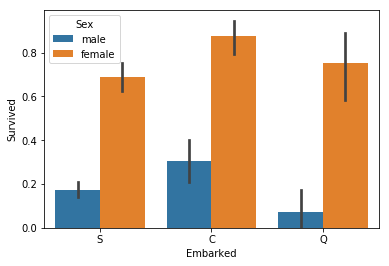

In [347]:
#compare Embarked and survival
#	C = Cherbourg, Q = Queenstown, S = Southampton
# passengers who embarked at Cherbourg appear more likely to have survived for some unexpected reason
# males who embarked at Queenstwon appear to have a lower chance of survival
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=titanic_df);


In [348]:
# most people embarked at Southampton
titanic_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [349]:
# only have a couple of null values in training set
titanic_df['Embarked'].isnull().sum()

2

In [350]:
# let's make embarked numeric for easier learning
titanic_df = encodeEmbark(titanic_df)
titanic_test = encodeEmbark(titanic_test)
titanic_df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,0


In [351]:
# is this becuase there is a relationship between Embarked and Class?
# no - there is only a 6.2% correleation
#corr = titanic_df.corr()
#corr

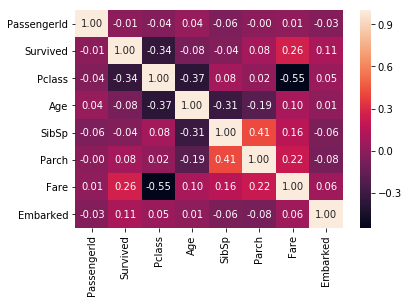

In [352]:
# Basic graphs to help understand data
# biggest correlations
# parch and sibsp are .41 positively correlated (makes sense -- both indications of a family travelling together)
# survived and fare are .26 positively correlated
# sibsp and Age are .31 negatively correlated (makes sense -- the older you are,the less likely you are to be travelling with your siblings)
# survived and pclass are -.34 negatively correlated
# pclass and age are .37 negatively correlated
# fare and pclass are .55 negatively correlated
# embarked isn't particularly correlated with any other feature
        
sns.heatmap(titanic_df.corr(), annot=True, fmt=".2f")

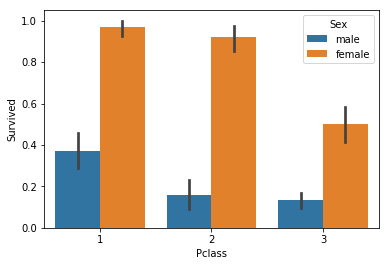

In [353]:
# compare Class and Surival by gender
# see upper class passengers more likely to survive and females much more liekly to surive in all classes
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=titanic_df);

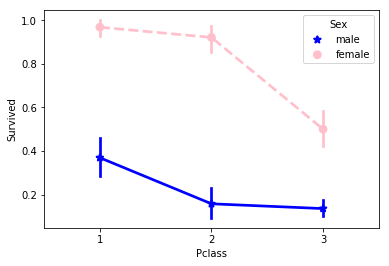

In [354]:
#plot pclass vs survival
# altnerative plot style
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=titanic_df,
palette={"male": "blue", "female": "pink"},
markers=["*", "o"], linestyles=["-", "--"]);

In [355]:
#Scatter plot -- SLOW!
#sns.pairplot(titanic_df, hue="Age")

*************************************************
Start Feature Engineering section
*************************************************

In [356]:
#look at family size by combining siblings/spouse and parent/child columns
titanic_df = createFamilySize(titanic_df)
titanic_test = createFamilySize(titanic_test)
titanic_df.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,0,6
91,92,0,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,347466,7.8542,NaN,0,0
424,425,0,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,0,2
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,1,2
433,434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.1250,NaN,0,0


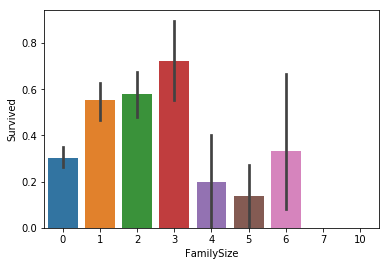

In [357]:
#plot impact of family size on survival
sns.barplot(x="FamilySize", y="Survived", data=titanic_df);

# seems best change of survival is with a small family 1-3
# survival chances seem to drop off if on own or if have a bigger family


In [358]:
#extract Cabin info
# first lets examine some non null cabin data
titanic_df[titanic_df['Cabin'].notnull()]['Cabin'].count()
# RESULT: have 204 rows with non null cabin data

# let's look at some sample datat
titanic_df[titanic_df['Cabin'].notnull()]['Cabin'].sample(10)
# most are in format C68, E46 etc
# see that we have some rows with multiple cabins: B51 B53 B55
# some rows only have Letter and no number

701            E24
88     C23 C25 C27
356            E33
591            D20
393            D36
252            C87
698            C68
512            E25
879            C50
625            D50
Name: Cabin, dtype: object

In [359]:
# For completeness, let's try extracting just the Cabin letter for further analysis
titanic_df['CabinLetter'] = titanic_df['Cabin'].str[0].fillna('ZZZ')
titanic_df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,1,ZZZ
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,ZZZ
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,0,1,C


In [360]:
# get count by cabin letter
titanic_df['CabinLetter'].value_counts()
#RESULT 687 unknown cabin letters

ZZZ    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: CabinLetter, dtype: int64

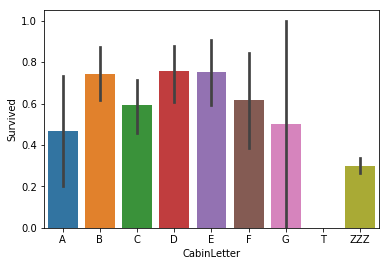

In [361]:
# plot relationship between Cabin floor and survival
titanic_df = titanic_df.sort_values(by='CabinLetter', ascending=True)

#.sort_values(by='AgeBand', ascending=True))
#sns.barplot(x="CabinLetter", y="Pclass", hue="Survived", data=titanic_df)
sns.barplot(x="CabinLetter", y="Survived",  data=titanic_df)
# Deck A is at top of ship

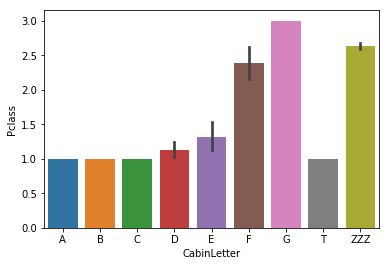

In [362]:
# check relationship between cabin letter and PClass
titanic_df = titanic_df.sort_values(by='CabinLetter', ascending=True)
sns.barplot(x="CabinLetter", y="Pclass",  data=titanic_df)


Decsion: don't believe cabin is a valuable field 
- correlated with class
- cannot extract deck level for majority of rows


In [363]:
# convert sex to number, 0=male, 1=female
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping).astype(int)
titanic_test['Sex'] = titanic_test['Sex'].map(sex_mapping).astype(int)

Age feature cleanup

In [364]:
# fill in missing ages
# first fill out titles
# add a computed title column
titanic_df = cleanupTitles(titanic_df)
titanic_test = cleanupTitles(titanic_test)
titanic_df.sample(3)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title
845,846,0,3,"Abbing, Mr. Anthony",0,42.0,0,0,C.A. 5547,7.5500,NaN,0,0,ZZZ,1
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",1,NaN,0,0,9234,7.7500,NaN,2,0,ZZZ,2
688,689,0,3,"Fischer, Mr. Eberhard Thelander",0,18.0,0,0,350036,7.7958,NaN,0,0,ZZZ,1


In [365]:
titanic_df = fillMissingAges(titanic_df)
titanic_test = fillMissingAges(titanic_test)

titanic_df.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title
821,822,1,3,"Lulic, Mr. Nikola",0,27.00000,0,0,315098,8.6625,NaN,0,0,ZZZ,1
774,775,1,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",1,54.00000,1,3,29105,23.0000,NaN,0,4,ZZZ,3
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",1,15.00000,1,0,2659,14.4542,NaN,1,1,ZZZ,3
650,651,0,3,"Mitkoff, Mr. Mito",0,32.89199,0,0,349221,7.8958,NaN,0,0,ZZZ,1


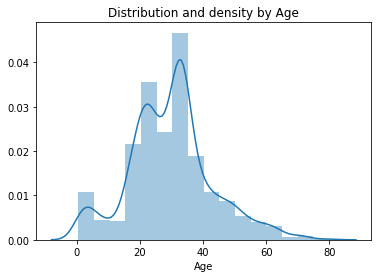

In [366]:
# examine age distribution
sns.distplot(titanic_df["Age"], bins=16)
plt.title("Distribution and density by Age")
plt.xlabel("Age")

In [367]:
# create Age bands
titanic_df['AgeBand'] = pd.cut(titanic_df['Age'], 5, labels=[1,2,3,4,5])
titanic_test['AgeBand'] = pd.cut(titanic_test['Age'], 5, labels=[1,2,3,4,5])
# create table of survival rates per age band
agedist_df = titanic_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

agedist_df

,AgeBand,Survived
0,1,0.548077
1,2,0.392670
2,3,0.320000
3,4,0.434783
4,5,0.090909


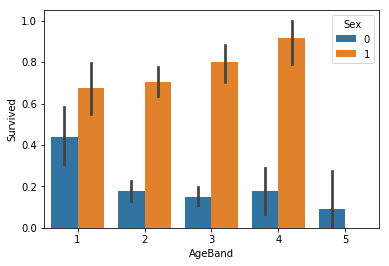

In [368]:
sns.barplot(x="AgeBand", y="Survived", hue="Sex", data=titanic_df);

#young males have best chance of survival among men
# older females have best chance of survival


Examine Fare Feature

In [369]:
titanic_df.Fare.describe() 

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [370]:
#get average fare for each class
fare_avg_class_df = titanic_df[['Pclass' , 'Fare']].groupby(['Pclass']).mean()
fare_avg_class_df

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [371]:
#titanic_df['Fare'].isnull().values

In [372]:
# Make sure we handle any null fares
# map the average fare based on pclass to the missing age values (nan)
fare_mapping = fare_avg_class_df.to_dict()
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df['Pclass'].map((fare_mapping['Fare'])))
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Pclass'].map((fare_mapping['Fare'])))
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,AgeBand
445,446,1,1,"Dodge, Master. Washington",0,4.00000,0,2,33638,81.8583,A34,0,2,A,4,1
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",0,56.00000,0,0,13213,35.5000,A26,1,0,A,1,4
475,476,0,1,"Clifford, Mr. George Quincy",0,32.89199,0,0,110465,52.0000,A14,0,0,A,1,3


In [373]:
# create bands out of fare to simplify
# set bins to quartile
bins = (-1, 0, 8, 15, 31, 1000)

titanic_df['FareBand'] = pd.cut(titanic_df['Fare'], bins,labels=[1,2,3,4,5])
titanic_test['FareBand'] = pd.cut(titanic_test['Fare'], bins,labels=[1,2,3,4,5])
#titanic_df.head(50)
# create table of survival rates per age band
faredist_df = titanic_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
faredist_df

,FareBand,Survived
0,1,0.066667
1,2,0.225664
2,3,0.285714
3,4,0.469194
4,5,0.581081


In [374]:
# examine size of bands
print(titanic_df.groupby('FareBand').size())



FareBand
1     15
2    226
3    217
4    211
5    222
dtype: int64


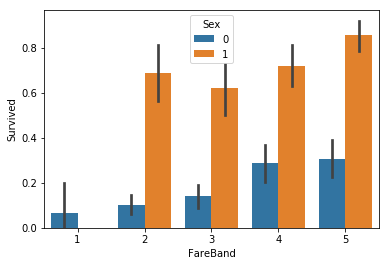

In [375]:
sns.barplot(x="FareBand", y="Survived", hue="Sex", data=titanic_df);

# first class have best chance of survival

In [376]:
titanic_test.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,AgeBand,FareBand
60,952,3,"Dika, Mr. Mirko",0,17.000000,0,0,349232,7.8958,NaN,0,0,1.0,2,2
417,1309,3,"Peter, Master. Michael J",0,7.406471,1,1,2668,22.3583,NaN,1,2,4.0,1,4
324,1216,1,"Kreuchen, Miss. Emilie",1,39.000000,0,0,24160,211.3375,NaN,0,0,2.0,3,5
130,1022,3,"Spinner, Mr. Henry John",0,32.000000,0,0,STON/OQ. 369943,8.0500,NaN,0,0,1.0,3,3
169,1061,3,"Hellstrom, Miss. Hilda Maria",1,22.000000,0,0,7548,8.9625,NaN,0,0,2.0,2,3
71,963,3,"Minkoff, Mr. Lazar",0,21.000000,0,0,349211,7.8958,NaN,0,0,1.0,2,2
110,1002,2,"Stanton, Mr. Samuel Ward",0,41.000000,0,0,237734,15.0458,NaN,1,0,1.0,3,4
143,1035,2,"Beauchamp, Mr. Henry James",0,28.000000,0,0,244358,26.0000,NaN,0,0,1.0,2,4
396,1288,3,"Colbert, Mr. Patrick",0,24.000000,0,0,371109,7.2500,NaN,2,0,1.0,2,2
289,1181,3,"Ford, Mr. Arthur",0,32.229947,0,0,A/5 1478,8.0500,NaN,0,0,1.0,3,3


Now ready to clean up training and test set to run models

In [377]:
# Now drop the columns we don't need to create our training nad test sets

#drop passengerid #drop Fare and Title
#drop age cabin embarked and name from data set used for training
# no longer dropping embark .drop('Embarked', axis=1)
titanic_train = titanic_df
titanic_train = titanic_df.drop('Ticket',axis=1).drop('Name', axis=1).drop('Age',axis=1).drop('Cabin',axis=1)
titanic_train = titanic_train.drop('Fare', axis=1).drop('Title', axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('CabinLetter',axis=1)
#drop('PassengerId', axis=1).
titanic_test = titanic_test.drop('Ticket',axis=1).drop('Name', axis=1).drop('Age',axis=1).drop('Cabin',axis=1)
titanic_test = titanic_test.drop('Fare', axis=1).drop('Title', axis=1).drop('SibSp',axis=1).drop('Parch',axis=1)

# Feb 17 - try dropping fare band
#titanic_test = titanic_test.drop('FareBand', axis=1)
#titanic_train = titanic_train.drop('FareBand', axis=1)
titanic_train.head(10)

,PassengerId,Survived,Pclass,Sex,Embarked,FamilySize,AgeBand,FareBand
445,446,1,1,0,0,2,1,5
647,648,1,1,0,1,0,4,5
475,476,0,1,0,0,0,3,5
174,175,0,1,0,1,0,4,4
23,24,1,1,0,0,0,2,5
556,557,1,1,1,1,1,3,5
284,285,0,1,0,0,0,3,4
583,584,0,1,0,1,0,3,5
185,186,0,1,0,0,0,3,5
630,631,1,1,0,0,0,5,4


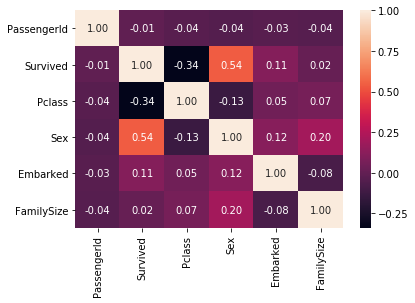

In [378]:
# now let's sanity check for any missed highly correlated features 
sns.heatmap(titanic_train.corr(), annot=True, fmt=".2f")

In [379]:

# make sure no null values have snuck through
nans = lambda titanic_test: titanic_test[titanic_test.isnull().any(axis=1)]
nans(titanic_test)

,PassengerId,Pclass,Sex,Embarked,FamilySize,AgeBand,FareBand


In [380]:
# create Y array and X array out of training set
y_vals = titanic_train['Survived']
titanic_train = titanic_train.drop('Survived', axis=1)

# we also need to preserve the passenger id so can submit the preditions
PassengerId_train = titanic_train['PassengerId']
titanic_train.drop('PassengerId', axis=1, inplace=True)

PassengerId_test =  titanic_test['PassengerId']
titanic_test.drop('PassengerId', axis=1, inplace=True)

# Train using K Nearest Neighbours model

In [381]:


# K controls how many nearest neighbours model tries to match with
#knn = KNeighborsClassifier(n_neighbors = 6)
#knn.fit(X_train, y_train)
#knn.score(X_test, y_test)

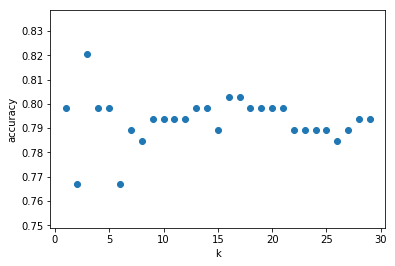

In [391]:
# create training and test splits out of overall training set so can get better idea of how we are doing
X_train, X_test, y_train, y_test = model_selection.train_test_split(titanic_train, y_vals, random_state=0)

# first choice is what value of K is optimal for this training set
# let's test model with range of K from 1 to 30 and plot accuracy results on reserved test set
# with KNN, it is important to scale features

k_range = range(1,30)
scores = []
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20,25,30]);

# best accuracy now is 6

In [383]:
scores.index(max(scores))


2

In [384]:
scores

[0.7982062780269058,
 0.76681614349775784,
 0.820627802690583,
 0.7982062780269058,
 0.7982062780269058,
 0.76681614349775784,
 0.78923766816143492,
 0.7847533632286996,
 0.79372197309417036,
 0.79372197309417036,
 0.79372197309417036,
 0.79372197309417036,
 0.7982062780269058,
 0.7982062780269058,
 0.78923766816143492,
 0.80269058295964124,
 0.80269058295964124,
 0.7982062780269058,
 0.7982062780269058,
 0.7982062780269058,
 0.7982062780269058,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.78923766816143492,
 0.7847533632286996,
 0.78923766816143492,
 0.79372197309417036,
 0.79372197309417036]

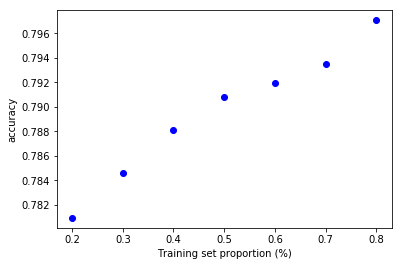

In [389]:
#impact of train test split proportion
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 3)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(titanic_train, y_vals, test_size = 1-s)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        knn.fit(X_train_scaled, y_train)
        
        scores.append(knn.score(X_test_scaled, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
# in this case, more data improves accuracyX_train_scaled

In [386]:
# since this model does better on larger data, let's train on 100% of the training data for submissions
# K controls how many nearest neighbours model tries to match with
#knn = KNeighborsClassifier(n_neighbors = 3)
#knn.fit(titanic_train, y_vals)
#y_predict = knn.predict(titanic_test.values)
#SHIFT TAB
#titanic_test['FareBand'].isnull()
titanic_test[titanic_test.isnull().any(axis=1)]

,Pclass,Sex,Embarked,FamilySize,AgeBand,FareBand


In [387]:
# create training and test splits out of overall training set so can get better idea of how we are doing
#X_train, X_test, y_train, y_test = model_selection.train_test_split(titanic_train, y_vals, random_state=0)
# test minmaxscaler
X_train_scaled = scaler.fit_transform(titanic_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(titanic_test)

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train_scaled, y_vals)
y_predict = knn.predict(X_test_scaled)

In [388]:
titanic_test['PassengerID'] = PassengerId_test
titanic_test['Survived'] = pd.Series(y_predict)
titanic_test.to_csv("C:/Users/blahjays/Documents/MachineLearning/Kaggle/knnoutput_scaled.csv", index=False)